# A Graph Neural Network (GNN)  from Scratch for semi-supervised learning
# Goals : 
1. An illustration of GNN for semi-supervised learning
2. A toy applicaion to community detection
3. A lecture on Structured Machine Learning

# Author: Romain Raveaux (romain.raveaux@univ-tours.fr)

## Install requirements

*   [Network](https://networkx.github.io/)
*   [Pytorch](https://pytorch.org/)

# The lecture
The content of the is notebook is based on the following lectures : 
Supervised Machine Learning for structured input/output: Polytech, Tours

*   1\. Introduction to supervised Machine Learning: A probabilistic introduction [PDF](http://romain.raveaux.free.fr/document/courssupervisedmachinelearningRaveaux.pdf)

*   2\. Connecting local models : The case of chains [PDF slides](http://romain.raveaux.free.fr/document/Connecting%20local%20models%20the%20case%20of%20chains%20.pdf)

*   3\. Connecting local models : Beyond chains and trees.[PDF slides](http://romain.raveaux.free.fr/document/Structured%20Output%20Learning.pdf)

*   4\. Machine Learning and Graphs : Introduction and problems [PDF slides](http://romain.raveaux.free.fr/document/cours%20IA%20DI5%20graphs%20introV2.pdf)

*   5\. **Graph Neural Networks.** [PDF slides](http://romain.raveaux.free.fr/document/graph%20neural%20networks%20romain%20raveaux.pdf)

*   6\. Graph Kernels. [PDF slides](http://romain.raveaux.free.fr/document/graph%20kernel%20romain%20raveaux.pdf)

*   7\. Appendix : Introduction to deep learning. [PDF slides](http://romain.raveaux.free.fr/document/DeepLearningRRv2.pdf)


In [33]:
#load of import
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.animation as animation
%matplotlib inline  
from IPython.display import HTML


# Zachary’s Karate Club
Briefly, Zachary’s Karate Club is a small social network where a conflict arises between the administrator and instructor in a karate club. The task is to predict which side of the conflict each member of the karate club chooses. The graph representation of the network can be seen below. Each node represents a member of the karate club and a link between members indicate that they interact outside the club. The Administrator and Instructor marked with A and I, respectively.

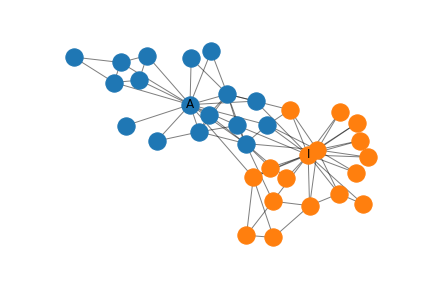

D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


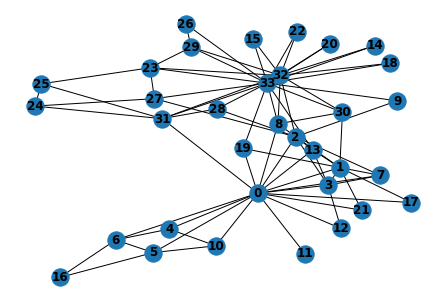

We have 34 nodes.
We have 78 edges.


In [34]:
from networkx import karate_club_graph, to_numpy_matrix
G = karate_club_graph()
#order = sorted(list(G.nodes()))
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

# Assign features to nodes or edges
Graph neural networks associate features with nodes and edges for training. For our classification example, we assign each node an input feature as a one-hot vector: node $v_i$‘s feature vector is $[0,…,1,…,0]$, where the $i^{th}$ position is one.

In DGL, you can add features for all nodes at once, using a feature tensor that batches node features along the first dimension. The code below adds the one-hot feature for all nodes:

In [35]:
import torch

eye=np.eye(34)

node_label = {}
for i in range(G.number_of_nodes()):
    node_label[i]=eye[i,:]
nx.set_node_attributes(G,node_label,'feature')


print(len(G.nodes))
print(len(G.edges))
print(G.number_of_nodes())
print(G.number_of_edges())


listnodes = list(G.nodes(data='feature'))
n=listnodes[0]
print(n)
print(n[1].shape)


34
78
34
78
(0, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(34,)


# Let 's us get the node features and the adjacency matrix

In [36]:
nodelist, nodesfeatures = map(list, zip(*G.nodes(data='feature')))
print(len(nodesfeatures))
nodesfeatures = np.array(nodesfeatures)
print(nodesfeatures.shape)
nodesfeatures = torch.from_numpy(nodesfeatures).float()
adjacencymatrix = np.array(nx.adjacency_matrix(G, nodelist=nodelist).todense())
print(adjacencymatrix.shape)
adjacencymatrix = torch.from_numpy(adjacencymatrix).float()

34
(34, 34)
(34, 34)


# Data preparation and initialization
We use one-hot vectors to initialize the node features. Since this is a semi-supervised setting, only the instructor (node 0) and the club president (node 33) are assigned labels. The implementation is available as follow.

In [37]:
#inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
print(labeled_nodes)
labels = torch.tensor([0, 1])  # their labels are different
print(labels)

tensor([ 0, 33])
tensor([0, 1])


## Define a Model : Graph Convolution layer

Firstly, we have to define a Graph Convolution layer.
$$f(H^{(l)},\hat{A})=\hat{A}.H^{(l)}.W^{(l)}$$
$$\hat{A}=A+I$$
A is the adjacency matrix and I the identity matrix.

# To do by the students
Complete the forward function

In [38]:
import torch
import torch.nn as nn

class GraphConvolution(nn.Module):
  """
     Graph convolution layer
  """
  
  def __init__(self, in_features, out_features, bias=True, batchnorm=False):
    super(GraphConvolution, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.bias = bias
    self.fc = nn.Linear(1*self.in_features, self.out_features, bias=self.bias)
    
    self.batchnorm = batchnorm
    
      
  #H are node features for all graphs batch
  #W are adjacency matrix for all graphs batch
  #A is the set of operators
  # GraphConv = A.H.W
  def forward(self, H, A):
    ### TO do by the students
    res = torch.matmul(A + torch.eye(A.shape[0]), H)

    #FC is just a linear function input multiplied by the paramaters W
    output = self.fc(res)

    return output

# Let us define the network : 2 graph conv layers
## To do by the students. 
Complete the forward function. 

Make the $\hat{A}$ matrix and give it to the conv layer.


In [39]:
# A Simple model with 2 graph conv layers 
# activation function are ReLus
class Net(nn.Module):
  def __init__(self, in_dim, hidden_dim, n_classes):
    super(Net, self).__init__()
    self.layers = nn.ModuleList([
        GraphConvolution(in_dim, hidden_dim),
        GraphConvolution(hidden_dim, n_classes)])
    
  def forward(self, h, adj):
    # Add self connections to the adjacency matrix
    ## Here stuf to do.
    ahat = adj + torch.eye(adj.shape[0])
    for conv in self.layers:
      h = F.relu(conv(h, ahat))
    return h

# Let us train 

The training loop is exactly the same as other PyTorch models. We (1) create an optimizer, (2) feed the inputs to the model, (3) calculate the loss and (4) use autograd to optimize the model

# Semi-supervised learning 
![image.png](http://romain.raveaux.free.fr/document/semisupervisedgnn.PNG)
Where $Z$ is the output of the graph neural network.
$l_{reg}$ can be computed as follows by the Frobenius norm : 
$$l_{reg}=||Z.Z^T -A ||_{F}^2 $$.


# Let us start with the supervised learning version
Here, nothing to change, just try to undestand the code.

In [40]:
nb_channels=34 
num_class=2
num_hidden=5
model = Net(nb_channels, num_hidden,num_class )
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lossfunction =  torch.nn.CrossEntropyLoss()
all_logits = []
optimizer.zero_grad()
for epoch in range(30):
    prediction = model(nodesfeatures, adjacencymatrix)
    # we save the prediction for visualization later
    all_logits.append(prediction.detach())
    
    # we only compute loss for labeled nodes
    loss0 = lossfunction(prediction[labeled_nodes], labels.long())
    loss=loss0
    #The crossentropy loss does the same as 
    #logp = F.log_softmax(prediction, 1)
    #loss0 = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 1.6255
Epoch 1 | Loss: 1.1595
Epoch 2 | Loss: 0.7852
Epoch 3 | Loss: 0.4729
Epoch 4 | Loss: 0.3950
Epoch 5 | Loss: 0.3768
Epoch 6 | Loss: 0.3638
Epoch 7 | Loss: 0.3559
Epoch 8 | Loss: 0.3516
Epoch 9 | Loss: 0.3494
Epoch 10 | Loss: 0.3482
Epoch 11 | Loss: 0.3476
Epoch 12 | Loss: 0.3472
Epoch 13 | Loss: 0.3470
Epoch 14 | Loss: 0.3468
Epoch 15 | Loss: 0.3468
Epoch 16 | Loss: 0.3467
Epoch 17 | Loss: 0.3467
Epoch 18 | Loss: 0.3466
Epoch 19 | Loss: 0.3466
Epoch 20 | Loss: 0.3466
Epoch 21 | Loss: 0.3466
Epoch 22 | Loss: 0.3466
Epoch 23 | Loss: 0.3466
Epoch 24 | Loss: 0.3466
Epoch 25 | Loss: 0.3466
Epoch 26 | Loss: 0.3466
Epoch 27 | Loss: 0.3466
Epoch 28 | Loss: 0.3466
Epoch 29 | Loss: 0.3466


# Visualization
This is a rather toy example, so it does not even have a validation or test set. Instead, Since the model produces an output feature of size 2 for each node, we can visualize by plotting the output feature in a 2D space. The following code animates the training process from initial guess (where the nodes are not classified correctly at all) to the end (where the nodes are linearly separable).

Here nothing to change. Just try to understand what it makes.

In [41]:

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(G, pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
plt.close()



D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


In [42]:

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())


RuntimeError: Requested MovieWriter (ffmpeg) not available

# Unsupervised Version only lreg
## Students job
1. Create a regularization function as presented above.
2. Use the function to create the $l_{red}$ loss.
3. Train and reach a value close to "Loss: 88.2357"
4. Vizualize (video)

In [61]:


nb_channels=34 
num_class=2
num_hidden=2
model = Net(nb_channels, num_hidden,num_class )
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
lossfunction =  torch.nn.CrossEntropyLoss()
all_logits = []
for epoch in range(100):
    prediction = model(nodesfeatures, adjacencymatrix)
    # we save the prediction for visualization later
    all_logits.append(prediction.detach())
    
    ## Stud to do here ##
    lossreg = torch.pow(torch.norm(torch.matmul(prediction, torch.t(prediction)) - adjacencymatrix), 2)
    loss=lossreg
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 149.6636
Epoch 1 | Loss: 136.4218
Epoch 2 | Loss: 139.5280
Epoch 3 | Loss: 131.5749
Epoch 4 | Loss: 130.2292
Epoch 5 | Loss: 130.0417
Epoch 6 | Loss: 127.3747
Epoch 7 | Loss: 122.7675
Epoch 8 | Loss: 120.6349
Epoch 9 | Loss: 119.7821
Epoch 10 | Loss: 117.0162
Epoch 11 | Loss: 113.0875
Epoch 12 | Loss: 111.6510
Epoch 13 | Loss: 111.2358
Epoch 14 | Loss: 110.5025
Epoch 15 | Loss: 109.5207
Epoch 16 | Loss: 108.8719
Epoch 17 | Loss: 108.7858
Epoch 18 | Loss: 108.6200
Epoch 19 | Loss: 107.6843
Epoch 20 | Loss: 106.7051
Epoch 21 | Loss: 106.3130
Epoch 22 | Loss: 106.2022
Epoch 23 | Loss: 105.8747
Epoch 24 | Loss: 105.3160
Epoch 25 | Loss: 104.8351
Epoch 26 | Loss: 104.6376
Epoch 27 | Loss: 104.4206
Epoch 28 | Loss: 103.9647
Epoch 29 | Loss: 103.5497
Epoch 30 | Loss: 103.3979
Epoch 31 | Loss: 103.3122
Epoch 32 | Loss: 103.0763
Epoch 33 | Loss: 102.7816
Epoch 34 | Loss: 102.6125
Epoch 35 | Loss: 102.4900
Epoch 36 | Loss: 102.2400
Epoch 37 | Loss: 101.9791
Epoch 38 | Loss: 101.8

In [60]:

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(G, pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
plt.close()



In [62]:

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())


RuntimeError: Requested MovieWriter (ffmpeg) not available

# Semi-Supervised version
## Students job here :
Here you mix $l_0$ and $l_{reg}$.
1. Compute $l_0$ as in the supervised version case.
2. Compute $l_{reg}
3. Add them up with a lambda coefficient.
4. Train and visualize. Try to reach a "Loss: 0.0938"

In [65]:
nb_channels=34 
num_class=2
num_hidden=2
lambdaa=0.0001
model = Net(nb_channels, num_hidden,num_class )
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
lossfunction =  torch.nn.CrossEntropyLoss()
all_logits = []
for epoch in range(100):
    prediction = model(nodesfeatures, adjacencymatrix)
    # we save the prediction for visualization later
    all_logits.append(prediction.detach())
    
    ### stuff to do#####
    loss0 = lossfunction(prediction[labeled_nodes], labels.long())
    
    
    lossreg = torch.pow(torch.norm(torch.matmul(prediction, torch.t(prediction)) - adjacencymatrix), 2)  
    
    loss= (lambdaa * lossreg) + loss0
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.9616
Epoch 1 | Loss: 0.8576
Epoch 2 | Loss: 0.7842
Epoch 3 | Loss: 0.7338
Epoch 4 | Loss: 0.6877
Epoch 5 | Loss: 0.6838
Epoch 6 | Loss: 0.6759
Epoch 7 | Loss: 0.6657
Epoch 8 | Loss: 0.6546
Epoch 9 | Loss: 0.6427
Epoch 10 | Loss: 0.6306
Epoch 11 | Loss: 0.6180
Epoch 12 | Loss: 0.6014
Epoch 13 | Loss: 0.5837
Epoch 14 | Loss: 0.5657
Epoch 15 | Loss: 0.5477
Epoch 16 | Loss: 0.5291
Epoch 17 | Loss: 0.5103
Epoch 18 | Loss: 0.4889
Epoch 19 | Loss: 0.4656
Epoch 20 | Loss: 0.4471
Epoch 21 | Loss: 0.4491
Epoch 22 | Loss: 0.4465
Epoch 23 | Loss: 0.4379
Epoch 24 | Loss: 0.4387
Epoch 25 | Loss: 0.4423
Epoch 26 | Loss: 0.4439
Epoch 27 | Loss: 0.4430
Epoch 28 | Loss: 0.4401
Epoch 29 | Loss: 0.4362
Epoch 30 | Loss: 0.4325
Epoch 31 | Loss: 0.4299
Epoch 32 | Loss: 0.4286
Epoch 33 | Loss: 0.4284
Epoch 34 | Loss: 0.4290
Epoch 35 | Loss: 0.4299
Epoch 36 | Loss: 0.4306
Epoch 37 | Loss: 0.4310
Epoch 38 | Loss: 0.4308
Epoch 39 | Loss: 0.4303
Epoch 40 | Loss: 0.4294
Epoch 41 | Loss: 0.4283
Ep

In [43]:

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(G, pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
plt.close()



In [44]:

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())


# Conclusion
Write a conclusion on the three learning paradigm. 
Give a conclusion to the pratical work.

In [ ]:
Nous pouvons conclure que l'utilisation de GNN pour classer les données du club de karaté de Zachary, l'apprentissage supervisé est le meilleur moyen d'obtenir les meilleurs résultats, c'est-à-dire d'obtenir le moins de pertes dans le moins d'itérations, suivi d'un apprentissage semi-supervisé. L'effet d'apprentissage de l'apprentissage non supervisé n'est pas idéal.